<a href="https://colab.research.google.com/github/YINZihua/yinzihua_PRIM_SSD_PyTorch/blob/main/PRIM3A_Image_Vision_Deepsort_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation for running Deepsort, cloned from official Deepsort Github repository

In [2]:
!git clone https://github.com/YINZihua/DeepSort_Component
%cd DeepSort_Component

Cloning into 'DeepSort_Component'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 46 (delta 15), reused 39 (delta 8), pack-reused 0
Unpacking objects: 100% (46/46), done.
/content/DeepSort_Component


In [3]:
!pwd  # Colab: should be in the path "/content/DeepSort_Component"

/content/DeepSort_Component


Now download the SSD model pretrained by COCO dataset and the corresponding labels

In [4]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz

!tar -xzf ssd_inception_v2_coco_2018_01_28.tar.gz
!cp ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb .
!rm -r ssd_inception_v2_coco_2018_01_28/
!rm ssd_inception_v2_coco_2018_01_28.tar.gz

--2021-01-09 21:39:13--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5056 (4.9K) [text/plain]
Saving to: ‘mscoco_label_map.pbtxt’

mscoco_label_map.pb 100%[===================>]   4.94K  --.-KB/s    in 0s      

2021-01-09 21:39:13 (60.6 MB/s) - ‘mscoco_label_map.pbtxt’ saved [5056/5056]

--2021-01-09 21:39:13--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.73.208, 2607:f8b0:4004:829::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.73.208|:80... connected.
HTTP request sent, awaiting response... 200 O

Some more utility functions provided by TensorFlow Project could be useful

In [5]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/label_map_util.py -P external/object_detection/utils/
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/protos/string_int_label_map.proto -P external/object_detection/protos

--2021-01-09 21:39:19--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/label_map_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12318 (12K) [text/plain]
Saving to: ‘external/object_detection/utils/label_map_util.py’

label_map_util.py   100%[===================>]  12.03K  --.-KB/s    in 0s      

2021-01-09 21:39:19 (113 MB/s) - ‘external/object_detection/utils/label_map_util.py’ saved [12318/12318]

--2021-01-09 21:39:19--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/protos/string_int_label_map.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

Download a surveillance video dataset provided by EPFL 

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1M9t7FBfGvpCZmfEOVN52qJUA9x1JVQDx', dest_path='./video_examples.zip')
!unzip -qq video_examples.zip 
!rm video_examples.zip
!mkdir video_output

# Establish a multi-camera people tracking applicaiton

## Import the necessary packages

In [7]:
from __future__ import division, print_function, absolute_import

import argparse
import os

import cv2
import numpy as np

import tensorflow as tf

from application_util import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker

from time import time 
import matplotlib.pyplot as plt


In [8]:
print('using Tensorflow version@'+str(tf.__version__))  # version@2.4.0 on Colab

using Tensorflow version@2.4.0


## Define the format of detections

In [9]:
class outputDetectionData():
  def __init__(self):
    self.bbox = np.asarray([])
    self.score_thresh = ()
    self.confidence = np.asarray([])
    self.classes = np.asarray([])
    self.category_box = ()

## Define the class of SSD prediction by tensorflow

In [10]:
class ssdPredictor():
  def __init__(self,
          model_path,
          label_path,
          score_thresh,
          ):
    self.score_thresh = score_thresh
    self.graph, self.sess = self.load_model(model_path)
    
    try:
      self.category_index, self.NUM_CLASSES = self.get_label_map(label_path)
    except: 
      self.category_index = None
      self.NUM_CLASSES = None
      print('Error: problem with label file path')


    [self.image_tensor, self.boxes_tensor,
     self.scores_tensor, self.classes_tensor,
     self.num_detections_tensor] = self.getTensors()

    self.output_data = outputDetectionData()
    self.output_data.score_thresh = score_thresh
    self.output_data.category_index = self.category_index


  def load_model(self,model_path):
    print('Loading Model File From: ' + model_path)

    def get_graph(PATH_TO_MODEL):
      detection_graph = tf.Graph() 
      # tf.function() is recommanded to replace tf.Graph() (some deprecated functionalities should be used)
      with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(PATH_TO_MODEL,'rb') as f:
          serialized_graph = f.read()
          od_graph_def.ParseFromString(serialized_graph)
          tf.import_graph_def(od_graph_def,name='')
          return detection_graph
    
    def load_graph_with_sess(PATH_TO_MODEL):
      graph = get_graph(PATH_TO_MODEL)
      sess = tf.compat.v1.Session(graph=graph)
      return graph,sess
    
    [graph,sess] = load_graph_with_sess(model_path)
    print('Finished Loading Model')
    return graph,sess

  def get_label_map(self, labels_path):
    with open(labels_path, "r") as f:
        file_content = f.read()

    data = file_content.split('item')
    output_data = {}
    num_classes = 0
    for indx, x in enumerate(data):
        if len(x) == 0:
            continue
        name = x.split('name:')[1].split('\n')[0].strip().replace('"','')
        _id = x.split('id:')[1].split('\n')[0].strip()
        display_name = x.split('display_name:')[1].split('\n')[0].strip().replace('"','')
        output_data[indx] = {
            'name':display_name,
            'id':_id,
            'display_name':name
        }
        num_classes += 1
    category_index = output_data
    return category_index, num_classes

  def getTensors(self):
    image_tensor = self.graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was
    # detected.
    boxes = self.graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = self.graph.get_tensor_by_name('detection_scores:0')
    classes = self.graph.get_tensor_by_name('detection_classes:0')
    num_detections = self.graph.get_tensor_by_name('num_detections:0')
    return [image_tensor, boxes, scores, classes, num_detections]


  def predict(self, image_np):
    # Actual detection.
    with self.sess.as_default(), self.graph.as_default():
      [boxes,scores,classes,temp_num_detections] = self.inferNN(image_np)
      boxes = np.squeeze(boxes)
      scores = np.squeeze(scores)
      classes = np.squeeze(classes)
      # Eliminate all values that do not meet the threshold.
      indices = [i for i, x in enumerate(scores > self.output_data.score_thresh) if x]
      scores = scores[indices]
      classes = classes[indices]
      boxes = boxes[indices]

      self.output_data.bbox = boxes
      self.output_data.scores = scores
      self.output_data.classes = classes
      # For now, we simply pass a reference to the image. We will use
      # this for predicting on the subset.
      self.output_data.img = image_np
      if self.output_data.bbox == ():
        self.output_data.bbox = np.asarray([])
    return self.output_data

  def inferNN(self, image_np):
    '''
    Perform inference on the image
    '''
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3] ??? Where could I find this information
    image_np_expanded = np.expand_dims(image_np, axis=0)
    [boxes, scores, classes, temp_num_detections] = self.sess.run([self.boxes_tensor, self.scores_tensor,
                                      self.classes_tensor, self.num_detections_tensor],
                                      feed_dict = {self.image_tensor: image_np_expanded}
                                      )
    return [boxes, scores, classes, temp_num_detections]



## Define the class used for the DeepSort tracking processing

In [11]:
class DeepSort():
  def __init__(self,
         min_confidence=0.8,
         nms_max_overlap=1.0,
         min_detection_height=0.0,
         max_cosine_distance=0.2,
         nn_budget=None,
         max_age=5):
    self.min_confidence = min_confidence
    self.nms_max_overlap = nms_max_overlap
    self.min_detection_height = min_detection_height
    self.max_cosine_distance = max_cosine_distance
    self.nn_budget = nn_budget

    self.metric = nn_matching.NearestNeighborDistanceMetric("cosine", self.max_cosine_distance,self.nn_budget)
    self.tracker = Tracker(self.metric,max_age)

  def apply(self,frame,tracking):
    hFrame,wFrame,_=frame.shape
    detections=[]
    

    for box, score in zip(tracking.bbox,tracking.scores):
      detections.append(Detection(box,score,frame)) 
    
    detections = [d for d in detections if d.confidence >= self.min_confidence]

    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, self.nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Update tracker
    self.tracker.predict()
    self.tracker.update(detections)

    # Count the number of confirmed trackers that we will output to the system
    track_count = 0
    # The first time we loop, we just count the number of confirmed trackers
    for track in self.tracker.tracks:
        #if not track.is_confirmed() or track.time_since_update > 1:
        #    continue
        track_count +=1
    tracking.tracker_ids = np.zeros(shape=(track_count))
    tracking.tracked_bbox = np.zeros(shape=(track_count,4))
    # The second time we loop, we store them
    idx = 0
    for track in self.tracker.tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
          continue
      bbox = track.to_tlbr_norm(wFrame, hFrame) 
      track_id = track.track_id
      tracking.tracked_bbox[idx] = bbox
      tracking.tracker_ids[idx] = track_id
            
      idx += 1
    
    return tracking



## Define the functionality for drawing the detection boxes

In [13]:
def drawTrackedBoxes(frame,tracking):
  hFrame,wFrame,_ = frame.shape
  for id, bbox in zip(tracking.tracker_ids,tracking.tracked_bbox):
    cv2.rectangle(frame,(int(bbox[0] * wFrame), int(bbox[1] * hFrame)),
              (int(bbox[2] * wFrame), int(bbox[3] * hFrame)),
              (0, 0, 255), 5)
    cv2.putText(frame, "ID:"+str(id),
          (int(bbox[0] * wFrame), int(bbox[1] * hFrame + 50)),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  return frame

def drawBoxes(frame,tracking):
  if tracking.bbox.size > 0:
    frame_with_tracking = drawTrackedBoxes(frame,tracking)
  return frame_with_tracking

Now we could run a tracking session over several video examples.
<br>
<br> 

## Firstly, set the path names

In [14]:
inputFileName = 'video_examples/4p-c0.avi'
outputFileName = 'video_output/output.avi'
ssdModelPath = 'frozen_inference_graph.pb'
ssdLabelPath = 'mscoco_label_map.pbtxt'
score_thresh = .5

## Then, run the SSD detector + DeepSort tracker over the video samples.

In [15]:
from time import time
cap = cv2.VideoCapture(inputFileName)
predictor = ssdPredictor(model_path=ssdModelPath, label_path=ssdLabelPath,score_thresh=score_thresh)
tracker = DeepSort()

# take the first frame of the video
ret, frame = cap.read()
hFrame,wFrame,_ = frame.shape

# apply the tracking over several videos
outputVideo = cv2.VideoWriter(outputFileName,cv2.VideoWriter_fourcc(*"MJPG"),30,(wFrame,hFrame))
cpt = 0
timesteps = [time()]
while True:
  print('\rcpt={}'.format(cpt),end='')
  ret, frame = cap.read()
  if ret == True:
    frameRGB = frame.copy()[:,:,::-1]
    tracking = predictor.predict(frameRGB)
    tracking = tracker.apply(frame=frame,tracking=tracking)
    trackResult = drawBoxes(frame=frame,tracking=tracking)
    outputVideo.write(trackResult)
    cpt += 1

  else:
    break
  timesteps.append(time())

cap.release()
outputVideo.release()

Loading Model File From: frozen_inference_graph.pb
Finished Loading Model
cpt=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


cpt=3914

## Illustrate the performance of the architecture

the average processing period is 70.436 millisec, which represents 14.2 FPS in average


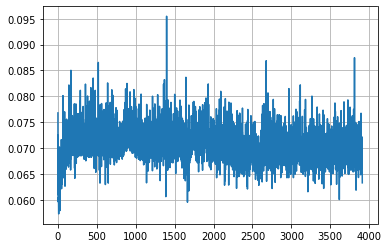

In [16]:
import matplotlib.pyplot as plt

timess = np.array(timesteps[1:]) - np.array(timesteps[:-1]) 
print('the average processing period is {:.5} millisec, which represents {:.4} FPS in average'.format(
                            1e3*np.mean(timess[1:]),
                            1/np.mean(timess[1:])))
plt.plot(timess[1:])
plt.grid()

When using only CPU unit on Colab, the performance is **4.855 FPS** in average.  <br>
When using GPU unit on Colab, the performance is **14.2 FPS** in average. <br>
When using machine in Telecom Paris (CPU Intel i7-8700 @ 3.2GHz with GPU Intel HD Graphics 630), the performance is **22.3 FPS** in average.